In [2]:
# import the necessary packages
from facebook_scraper import get_posts
from twitter_scraper import get_tweets
import seaborn as sns
import pandas as pd
import numpy as np
import time
import json
import re

from AttributeRelevance import *
from Features import *

# Part - 1: Data Collection

## Scrape facebook

In [2]:
# define a function to scrape facebook posts
def scrape_facebook(accounts):
    posts = []
    count = 0
    for account in accounts:
        for post in get_posts(account):
            try:
                post_dict = {}
                post_dict["post_id"] = post["post_id"]
                post_dict["text"] = post["text"]
                post_dict["post_text"] = post["post_text"]
                post_dict["shared_text"] = post["shared_text"]
                post_dict["time"] = post["time"]
                post_dict["image"] = post["image"]
                post_dict["video"] = post["video"]
                post_dict["video_thumbnail"] = post["video_thumbnail"]
                post_dict["video_id"] = post["video_id"]
                post_dict["likes"] = post["likes"]
                post_dict["comments"] = post["comments"]
                post_dict["shares"] = post["shares"]
                post_dict["post_url"] = post["post_url"]
                post_dict["link"] = post["link"]
                post_dict["user_id"] = post["user_id"]
                post_dict["images"] = post["images"]
                posts.append(post_dict)
            except:
                continue
        count += 1
        print(f"complete scrapping {count} accounts out of {len(accounts)} accounts")
            
    return posts

In [3]:
# facebook pages to be scrape which are related to SRH and GBV
facebook_accounts = ["SRHMJournal", "FSRH.UK", "mmsa.scora", "BMJ.SRH", 
                     "BLreproductivehealth", "actioncanadaSHR", "GBVPrevNetwork", 
                     "StopGBVatWork", "16DaysCampaign", "SayNO.UNiTE", "TheYellowMovementAau"]

# scrape facebook posts related to SRH and GBV
start = time.time()
posts = scrape_facebook(facebook_accounts)
end = time.time()
print(f"data scraping takes: {(end - start)} seconds")
fb_posts_df = pd.DataFrame(posts)
fb_posts_df.shape

complete scrapping 1 accounts out of 11 accounts
complete scrapping 2 accounts out of 11 accounts
complete scrapping 3 accounts out of 11 accounts
complete scrapping 4 accounts out of 11 accounts
complete scrapping 5 accounts out of 11 accounts
complete scrapping 6 accounts out of 11 accounts
complete scrapping 7 accounts out of 11 accounts
complete scrapping 8 accounts out of 11 accounts
complete scrapping 9 accounts out of 11 accounts
complete scrapping 10 accounts out of 11 accounts
complete scrapping 11 accounts out of 11 accounts
data scraping takes: 1020.8554711341858 seconds
            post_id                                               text  \
0  4183582811698940  New research finds that by using #photovoice, ...   
1  4181041485286406  We cannot overlook #reprohealth and #reprorigh...   
2  4179768305413724  Our latest editorial is now available online. ...   
3  4178431158880772  Evidence of the #health system challenges to p...   
4  4176874072369814  President Biden repe

In [4]:
AWAREsg_df = pd.read_csv("../data/AWAREsg.csv")
AWAREsg_df.shape

(38, 16)

In [5]:
emerge_global_df = pd.read_csv("../data/EmergeGlobal.csv")
emerge_global_df = emerge_global_df.drop(columns=["Unnamed: 16", "Unnamed: 17"])
emerge_global_df.shape

(38, 16)

In [6]:
equality_now_df = pd.read_csv("../data/equalitynow.csv")
equality_now_df.shape

(38, 16)

In [7]:
girls_are_not_for_sale_df = pd.read_csv("../data/girlsarenotforsale.csv")
girls_are_not_for_sale_df.shape

(26, 16)

In [130]:
# concatinating the scrapped dataframes
frames = [fb_posts_df, AWAREsg_df, emerge_global_df, equality_now_df, girls_are_not_for_sale_df]
df = pd.concat(frames)
df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images
0,4183582811698940,"New research finds that by using #photovoice, ...","New research finds that by using #photovoice, ...",,2021-02-04 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,2.0,0.0,0,None,https://bit.ly/2XZFJyV,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...
1,4181041485286406,We cannot overlook #reprohealth and #reprorigh...,We cannot overlook #reprohealth and #reprorigh...,SRHM.ORG\nCall for Papers: COVID-19,2021-02-03 13:25:03,None,None,None,None,3.0,0.0,0,https://facebook.com/story.php?story_fbid=4181...,http://www.srhm.org/call-for-papers-covid19/,126697227387539,[]
2,4179768305413724,Our latest editorial is now available online. ...,Our latest editorial is now available online. ...,TANDFONLINE.COM\nA round-up of articles in 2020,2021-02-03 00:41:05,None,None,None,None,0.0,0.0,0,https://facebook.com/story.php?story_fbid=4179...,https://bit.ly/3oDquXj,126697227387539,[]
3,4178431158880772,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,3.0,0.0,0,None,https://bit.ly/3qC86PZ,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...
4,4176874072369814,President Biden repeals the Global Gag Rule - ...,President Biden repeals the Global Gag Rule - ...,,2021-02-01 21:48:36,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,None,None,None,1.0,0.0,0,None,https://mailchi.mp/c0533878aec1/your-april-new...,126697227387539,[https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0...


In [131]:
df.shape

(564, 16)

In [132]:
df.to_csv('../data/fb_posts.csv', index=False)

In [10]:
df = pd.read_csv('../data/fb_posts.csv')
df.shape

(564, 16)

## Scrape twitter

In [7]:
# define a function to scrape twitter tweets
def scrape_twitter(accounts):
    tweets = []
    count = 0
    for account in accounts:
        for tweet in get_tweets(account):
            try:
                tweet_dict = {}
                tweet_dict["tweetId"] = tweet["tweetId"]
                tweet_dict["userId"] = tweet["userId"]
                tweet_dict["username"] = tweet["username"]
                tweet_dict["tweetUrl"] = tweet["tweetUrl"]
                tweet_dict["isRetweet"] = tweet["isRetweet"]
                tweet_dict["isPinned"] = tweet["isPinned"]
                tweet_dict["time"] = tweet["time"]
                tweet_dict["text"] = tweet["text"]
                tweet_dict["replies"] = tweet["replies"]
                tweet_dict["retweets"] = tweet["retweets"]
                tweet_dict["comments"] = tweet["comments"]
                tweet_dict["likes"] = tweet["likes"]
                tweet_dict["entries"] = tweet["entries"]
                tweets.append(tweet_dict)
            except:
                continue
        count += 1
        print(f"complete scrapping {count} accounts out of {len(accounts)} accounts")
            
    return posts

In [10]:
# facebook pages to be scrape which are related to SRH and GBV
twitter_accounts = ["psrhjournal", "bmj_srh", "reprod_health"]

# scrape facebook posts related to SRH and GBV
start = time.time()
tweets = scrape_twitter(twitter_accounts)
end = time.time()
print(f"data scraping takes: {(end - start)} seconds")
twitter_tweets_df = pd.DataFrame(tweets)
twitter_tweets_df.shape

In [ ]:
twitter_tweets_df.head()

# Part - 2: Data Cleaning and Transforming

## Text cleaning

In [11]:
# drop amharic posts
df = df[df['text'].apply(lambda txt: not re.search(r"[\u1200-\u137F]+", str(txt)))]
df.shape

(529, 16)

In [12]:
# drop post with empty text
df["text"] = df["text"].replace({"", np.nan})
df = df.dropna(subset=["text"])
df.shape

(520, 16)

In [13]:
# content based cleaning 
# define keyword group count
def keyword_group_count(txt):
    f = open("../data/keywords.json")
    keywords = json.load(f)
    f.close()
    count = 0
    for keyword_list in keywords.values():
        for keyword in keyword_list:
            if str(keyword).lower() in txt.lower():
                count += 1
                break
    return count

# add keyword group count columns
df["keyword_group_count"] = df["text"].apply(lambda txt: keyword_group_count(txt))
df = df[df["keyword_group_count"] >= 2]
df.shape

(90, 17)

## Labeling

In [14]:
# label the posts based on the mean of comments, likes, and shares
df["comments"] = df["comments"].apply(lambda x: (x - df["comments"].mean())/df["comments"].std())
df["likes"] = df["likes"].apply(lambda x: (x - df["likes"].mean())/df["likes"].std())
df["shares"] = df["shares"].apply(lambda x: (x - df["shares"].mean())/df["shares"].std())

df["label"] = df[["comments", "likes", "shares"]].mean(axis=1)
df["label"] = df["label"].apply(lambda x: 1 if x >= df["label"].mean() else 0)

df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images,keyword_group_count,label
3,4.178431e+15,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,NaN,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3qC86PZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
7,4.165486e+15,Unwanted pregnancy and unsafe #abortion contri...,Unwanted pregnancy and unsafe #abortion contri...,NaN,2021-01-28 13:25:04,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3iw0mMF,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
19,4.110924e+15,The handbook challenges readers to consider #m...,The handbook challenges readers to consider #m...,NaN,2021-01-08 20:15:16,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.055809,-0.342904,NaN,https://bit.ly/3h2N4Xi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
21,4.107126e+15,This article focuses on barriers #women face a...,This article focuses on barriers #women face a...,NaN,2021-01-07 11:15:06,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3mAd5hZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0
34,4.071571e+15,New commentary now online: Comprehensive sexua...,New commentary now online: Comprehensive sexua...,NaN,2020-12-24 12:15:10,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.184597,-0.366248,-0.342904,NaN,https://bit.ly/3h1iFsi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,3,0


## Add sub-topics columns

In [15]:
# add content_size column
def classifiy_content_size(content_size, quantieles):
    if content_size <= quantieles[0]:
        return "short"
    elif content_size >= quantieles[1]:
        return "long"
    else:
        return "meduim"

# extract text content size 
df["content_size"] = df["text"].apply(lambda txt: len(txt))
describe = df["content_size"].describe()
quantieles = [describe["25%"], describe["75%"]]
df["content_size"] = df["content_size"].apply(lambda content_size: classifiy_content_size(content_size, quantieles))
df.head()

,post_id,text,post_text,shared_text,time,image,video,video_thumbnail,video_id,likes,comments,shares,post_url,link,user_id,images,keyword_group_count,label,content_size
3,4.178431e+15,Evidence of the #health system challenges to p...,Evidence of the #health system challenges to p...,NaN,2021-02-02 13:25:03,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3qC86PZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
7,4.165486e+15,Unwanted pregnancy and unsafe #abortion contri...,Unwanted pregnancy and unsafe #abortion contri...,NaN,2021-01-28 13:25:04,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3iw0mMF,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
19,4.110924e+15,The handbook challenges readers to consider #m...,The handbook challenges readers to consider #m...,NaN,2021-01-08 20:15:16,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.055809,-0.342904,NaN,https://bit.ly/3h2N4Xi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
21,4.107126e+15,This article focuses on barriers #women face a...,This article focuses on barriers #women face a...,NaN,2021-01-07 11:15:06,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.181017,-0.366248,-0.342904,NaN,https://bit.ly/3mAd5hZ,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,2,0,short
34,4.071571e+15,New commentary now online: Comprehensive sexua...,New commentary now online: Comprehensive sexua...,NaN,2020-12-24 12:15:10,https://scontent.fadd1-1.fna.fbcdn.net/v/t1.0-...,NaN,NaN,NaN,-0.184597,-0.366248,-0.342904,NaN,https://bit.ly/3h1iFsi,126697227387539,['https://scontent.fadd1-1.fna.fbcdn.net/v/t1....,3,0,short


In [16]:
quantieles

[281.0, 674.25]

In [20]:
# find the relevant sub_topics
sub_topics = {"youth": ["Youth", "Young people", "Adolescent"],
              "sexual": ["Sexual health", "Reproductive health", "sex", "safer sex", "family planning", "condom", "HIV/AIDS", "Abortion", "Cervical cancer", "Menstrual cycle", "fertility", "relationship with opposite sex"],
              "GBV": ["Gender-based violence", "rape", "sexual harassment", "forced marriage"]}
with open("../data/sub_topics.csv", "w") as f:
    json.dump(sub_topics, f)

In [23]:
# add relevant sub_topics columns
for (sub_topic_name, sub_topic_list) in sub_topics.items():
    df[sub_topic_name] = df['text'].apply(lambda txt: ','.join([str(sub_topic) for sub_topic in sub_topic_list \
                                                if (sub_topic.lower() in str(txt).lower())]))
    df[sub_topic_name] = df[sub_topic_name].apply(lambda x: x.split(','))
    df = df.explode(sub_topic_name)
    
df = df[["text", "content_size", "youth", "sexual", "GBV", "label"]]
df = df.reset_index()
df = df.drop(columns="index")
df.head()

,text,content_size,youth,sexual,GBV,label
0,Evidence of the #health system challenges to p...,short,,,,0
1,Unwanted pregnancy and unsafe #abortion contri...,short,,Abortion,,0
2,The handbook challenges readers to consider #m...,short,,Sexual health,,0
3,The handbook challenges readers to consider #m...,short,,sex,,0
4,This article focuses on barriers #women face a...,short,,,,0


In [25]:
df.to_csv('../data/cleaned_fb_posts.csv')

# Part - 3: Data Analysis

## Convert sub-topics to bins

In [26]:
feats_dict = {}

for col in [c for c in df.columns if (c != 'label' and c != 'text')]:
    feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

## Information value analysis

In [27]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()

In [28]:
iv_df = ar.analyze(feats, iv, interpretation=True)
iv_df.to_csv('../data/iv_data.csv')
iv_df

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,iv,iv_interpretation
GBV,0.307190,strong
content_size,0.288135,medium
sexual,0.282107,medium
youth,0.173033,medium


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


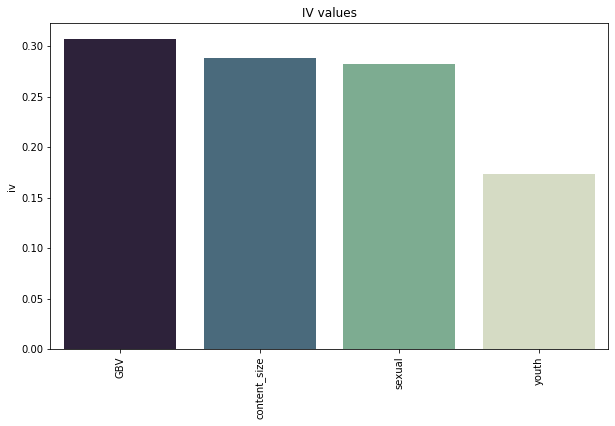

In [29]:
ar.draw_iv(feats, iv)

## Weight of evidence analysis

In [40]:
(content_size_iv_df, content_size_iv_value) = iv.calculate_iv(feats[0])
(youth_iv_df, youth_iv_value) = iv.calculate_iv(feats[1])
(sexual_iv_df, sexual_iv_value) = iv.calculate_iv(feats[2])
(GBV_iv_df, GBV_iv_value) = iv.calculate_iv(feats[3])

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
content_size_iv_df

,content_size,count,good,bad,perc_good,perc_bad,perc_diff,woe,iv
0,long,30,8,22,0.470588,0.22,0.250588,0.760356,0.190536
1,meduim,59,6,53,0.352941,0.53,-0.177059,-0.406576,0.071988
2,short,28,3,25,0.176471,0.25,-0.073529,-0.348307,0.025611


In [42]:
# rename columns and add new ones
content_size_iv_df = content_size_iv_df.rename(columns={"content_size": "contents"})
content_size_iv_df["sub_topics"] = "content_size"

youth_iv_df = youth_iv_df.rename(columns={"youth": "contents"})
youth_iv_df["sub_topics"] = "youth"

sexual_iv_df = sexual_iv_df.rename(columns={"sexual": "contents"})
sexual_iv_df["sub_topics"] = "sexual"

GBV_iv_df = GBV_iv_df.rename(columns={"GBV": "contents"})
GBV_iv_df["sub_topics"] = "GBV"

# concatinating the dataframes
frames = [content_size_iv_df, youth_iv_df, sexual_iv_df, GBV_iv_df]
woe_df = pd.concat(frames)
woe_df = woe_df[["sub_topics", "contents", "woe"]]
woe_df = woe_df[woe_df["contents"] != ""]
woe_df = woe_df.set_index("contents")
woe_df.to_csv('../data/woe_data.csv')
woe_df

,sub_topics,woe
contents,,
long,content_size,0.760356
meduim,content_size,-0.406576
short,content_size,-0.348307
Adolescent,youth,1.771957
Young people,youth,0.000000
Youth,youth,0.000000
Abortion,sexual,0.000000
HIV/AIDS,sexual,0.000000
Reproductive health,sexual,-0.867100


/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


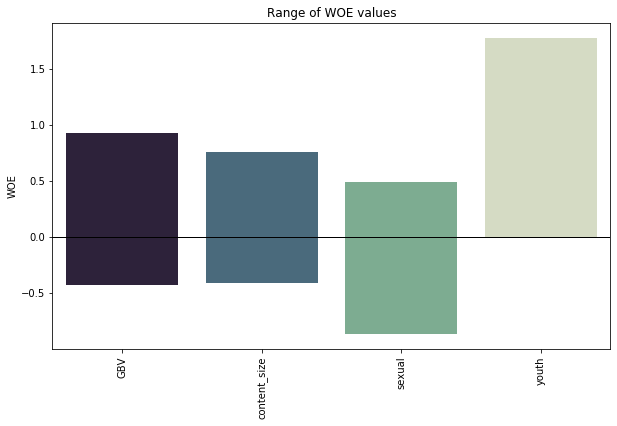

In [43]:
ar.draw_woe_extremes(feats, iv)

/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yony/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


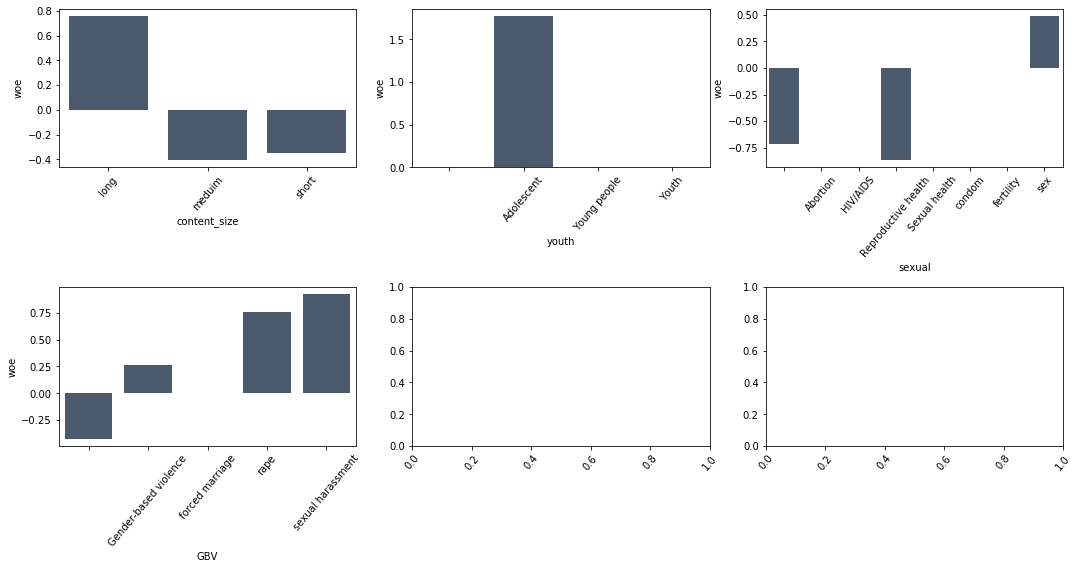

In [44]:
f_draw = ["content_size", "youth", "sexual", "GBV"]
feats_draw = [v for k, v in feats_dict.items() if k in f_draw]
ar.draw_woe_multiplot(feats_draw, iv)

In [36]:
df["sexual"].value_counts()

sex                    69
Reproductive health    15
                       13
Abortion               11
Sexual health           6
condom                  1
fertility               1
HIV/AIDS                1
Name: sexual, dtype: int64